In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


import datetime

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

import optuna

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

In [2]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]

### Importing dataframe and merging long

In [3]:
merge_df = pd.DataFrame()
for i,x in zip(regions, fire_regions):
    df = pd.read_csv('{}_iso.csv'.format(i))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', x]]
    df = pd.melt(df, id_vars = 'Date', value_vars = x)
    df['variable'] = df['variable'].replace(to_replace = x, value = i)
    merge_df = pd.concat([merge_df, df])
    merge_df.reset_index(drop=True, inplace=True)
    
merge_df.rename(columns = {'value':'Estimated_fire_area'}, inplace=True)

### Feature Engineering Time

In [4]:
_midmonth_of_year = [
  15.5,   # the middle of January is betwen Day 15-16
  45,     # February
  75,     # March
  106,    # April
  136.5,
  167,
  197.5,
  228.5,
  259,
  289.5,
  320,
  350.5   # December
]
# total number of years in dataframe
_len = len(merge_df) - 1
_total_years = merge_df.loc[_len, 'Date'].year - merge_df.loc[0, 'Date'].year +1 
_cumulative = []
# creating a list of cumulative middays of the year
# For exmaple _cumulative[0] would be the cumulative middays of the first year
# and _cumulative[1] would be the cumulative middays of second year
for i in range(_total_years):
    _cumulative.append(np.array(_midmonth_of_year) + (i * 365.2425)) # total number of days
    
    
# I will need to transpose this list to get cumulative middays for January and February
_array = np.array(_cumulative)

_start_day = merge_df.loc[0, 'Date'].dayofyear
_day_range = np.array(range(_start_day, len(merge_df) + 1))

alpha = 310 # change alpha to make bumps thinner or thicker
for i, month in zip(_array.T, range(1,13)):
    _list = []
    for each in i:
        _list.append(np.exp(-1/(alpha) * (_day_range - each)**2))

    _list = np.array(_list)
    _max = _list.max(axis = 0)

    merge_df['month_{}'.format(month)] = _max

In [5]:

date_time = pd.to_datetime(merge_df['Date'], format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
merge_df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
merge_df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
# merge_df['month'] = merge_df['Date'].dt.month
# merge_df['dayofweek'] = merge_df['Date'].dt.dayofweek

In [6]:
# change region variable to number
le = LabelEncoder()
merge_df['variable'] = le.fit_transform(merge_df['variable'])
merge_df

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_sin,year_cos
0,2005-01-01,0,0.000000,0.507517,0.001940,2.130091e-08,3.585311e-16,1.897618e-26,2.485555e-39,8.056949e-55,3.105164e-73,5.586864e-94,2.487621e-117,2.741151e-143,7.475055e-172,0.012400,0.999923
1,2005-01-02,0,0.000000,0.555491,0.002568,3.422455e-08,7.035994e-16,4.533831e-26,7.229992e-39,2.853271e-54,1.343123e-72,2.942099e-93,1.594892e-116,2.139627e-142,7.103583e-171,0.029599,0.999562
2,2005-01-03,0,0.000000,0.604090,0.003379,5.463557e-08,1.371899e-15,1.076267e-25,2.089538e-38,1.003953e-53,5.772251e-72,1.539376e-92,1.015960e-115,1.659363e-141,6.707159e-170,0.046789,0.998905
3,2005-01-04,0,8.680000,0.652716,0.004416,8.665854e-08,2.657766e-15,2.538473e-25,6.000135e-38,3.509797e-53,2.464749e-71,8.002580e-92,6.430134e-115,1.278623e-140,6.292133e-169,0.063965,0.997952
4,2005-01-05,0,16.611250,0.700721,0.005734,1.365668e-07,5.115754e-15,5.948718e-25,1.711866e-37,1.219126e-52,1.045679e-70,4.133458e-91,4.043538e-114,9.789084e-140,5.864827e-168,0.081122,0.996704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,6,32.970000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.900812,0.434210
40477,2020-10-28,6,20.840625,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.893209,0.449641
40478,2020-10-29,6,136.083077,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.885342,0.464940
40479,2020-10-30,6,42.397895,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.877214,0.480100


In [7]:
# Creating 3 sliced dataframes
train_set = merge_df.loc[merge_df['Date'] <= '2019-10-31'].copy(deep=True)
test_set = merge_df.loc[(merge_df['Date'] > '2019-10-31') & (merge_df['Date'] <= '2020-02-28')].copy(deep=True)
test_set['variable'] = le.inverse_transform(test_set['variable'])
pred_set = merge_df.loc[(merge_df['Date'] > '2019-10-31') & (merge_df['Date'] <= '2020-02-28')].copy(deep=True)
pred_set['Estimated_fire_area'] = np.nan
print(pred_set.shape)
pred_set.tail()

(840, 17)


,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_sin,year_cos
40230,2020-02-24,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.801849,0.597526
40231,2020-02-25,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812009,0.583645
40232,2020-02-26,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.821929,0.569590
40233,2020-02-27,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.831605,0.555367
40234,2020-02-28,6,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841036,0.540980


In [8]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
    _df['lag_1'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(1)
    _df['lag_2'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(2)
    _df['lag_3'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(3)
    _df['lag_4'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(4)
    _df['lag_5'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(5)
    _df['lag_6'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(6)
    _df['lag_7'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(7)
    _df['lag_28'] = _df[['variable', 'Estimated_fire_area']].groupby('variable')['Estimated_fire_area'].shift(28)

    _df['mean_lag7_roll7'] = _df[['variable', 'Estimated_fire_area', 'lag_7']].groupby('variable')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['variable', 'Estimated_fire_area', 'lag_7']].groupby('variable')['lag_7'].apply(lambda x: x.rolling(28).mean())
#     _df['mean_lag28_roll7'] = _df[['variable', 'Estimated_fire_area', 'lag_28']].groupby('variable')['lag_28'].apply(lambda x: x.rolling(7).mean())
#     _df['mean_lag28_roll28'] = _df[['variable', 'Estimated_fire_area', 'lag_28']].groupby('variable')['lag_28'].apply(lambda x: x.rolling(28).mean())
    
    return _df

In [9]:
train_set = date_lags(train_set)

In [10]:
categorical_features = ['variable']
useless_cols = ['Date', 'Estimated_fire_area']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['Estimated_fire_area']

In [11]:

X_valid = train_set.loc[train_set['Date'] >= '2018-11-01'][train_cols]
y_valid = train_set.loc[train_set['Date'] >= '2018-11-01']['Estimated_fire_area']
X_train = train_set.loc[train_set['Date'] < '2018-11-01'][train_cols]
y_train = train_set.loc[train_set['Date'] < '2018-11-01']['Estimated_fire_area']

In [12]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False)

In [13]:
def objective(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie']),
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 64),
        'num_leaves': trial.suggest_int('num_leaves', 54, 124),
        'metric' :'mape',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=25000, valid_sets = y_valid_data, verbose_eval=1000, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['Estimated_fire_area'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    
    _pred_set = train_roll.loc[(train_roll['Date'] >= '2019-11-01') & (train_roll['Date'] <= '2020-02-28')].copy(deep=True)
    _pred_set['variable'] = le.inverse_transform(_pred_set['variable'])
    _pred_pivot = pd.pivot(_pred_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
    
#     test_set['variable'] = le.inverse_transform(test_set['variable'])
    _test_pivot = pd.pivot(test_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
    _lgbm_rmse = mean_squared_error(_test_pivot.values.flatten(), _pred_pivot.values.flatten())
    
    return _lgbm_rmse

In [14]:
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [15]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 55,
    'num_leaves': 63,
    'metric' :'mape',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.8586230379455113,
    'feature_fraction': 0.5075743082081623,
    'lambda_l1' : 0.2720377201421843,
    'lambda_l2' : 0.3814253476194106,
    'verbosity': 1

}

In [16]:
# {'objective': 'poisson', 'max_depth': 55, 'num_leaves': 63, 'bag_frac': 0.8586230379455113, 'feat_frac': 0.5075743082081623, 'l1': 0.2720377201421843, 'l2': 0.3814253476194106}

In [17]:
m_lgb = lgb.train(params, train_data,num_boost_round=100000, valid_sets = y_valid_data, verbose_eval=500, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[500]	valid_0's mape: 2.36869
[1000]	valid_0's mape: 2.26928
[1500]	valid_0's mape: 2.15915
[2000]	valid_0's mape: 2.07949
[2500]	valid_0's mape: 2.00105
[3000]	valid_0's mape: 1.94601
[3500]	valid_0's mape: 1.88145
[4000]	valid_0's mape: 1.82312
[4500]	valid_0's mape: 1.78372
[5000]	valid_0's mape: 1.74439
[5500]	valid_0's mape: 1.70972
[6000]	valid_0's mape: 1.67803
[6500]	valid_0's mape: 1.65238
[7000]	valid_0's mape: 1.63026
[7500]	valid_0's mape: 1.60933
[8000]	valid_0's mape: 1.58984
[8500]	valid_0's mape: 1.56794
[9000]	valid_0's mape: 1.53957
[9500]	valid_0's mape: 1.5182
[10000]	valid_0's mape: 1.50011
[10500]	valid_0's mape: 1.48048
[11000]	valid_0's mape: 1.46732
[11500]	valid_0's mape: 1.45387
[12000]	valid_0's mape: 1.44023
[12500]	valid_0's mape: 1.43077
[13000]	valid_0's mape: 1.42016
[13500]	valid_0's mape: 1.40878
[14000]	valid_0's mape: 1.39671
[14500]	valid_0's mape: 1.38773
[15000]	valid_0's mape: 1.37857

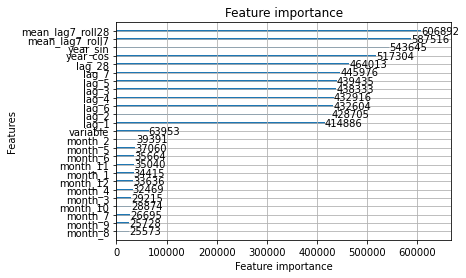

In [18]:
lgb.plot_importance(m_lgb)

In [19]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['Date'] == (datetime.datetime(2019, 10, 31) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['Estimated_fire_area'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

 24%|██▍       | 120/499 [00:22<01:11,  5.29it/s]


end of loop


In [20]:
train_roll

,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28
0,2005-01-01,0,0.000000,0.507517,0.001940,2.130091e-08,3.585311e-16,1.897618e-26,2.485555e-39,8.056949e-55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,0,0.000000,0.555491,0.002568,3.422455e-08,7.035994e-16,4.533831e-26,7.229992e-39,2.853271e-54,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,0,0.000000,0.604090,0.003379,5.463557e-08,1.371899e-15,1.076267e-25,2.089538e-38,1.003953e-53,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,0,8.680000,0.652716,0.004416,8.665854e-08,2.657766e-15,2.538473e-25,6.000135e-38,3.509797e-53,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,0,16.611250,0.700721,0.005734,1.365668e-07,5.115754e-15,5.948718e-25,1.711866e-37,1.219126e-52,...,8.680000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38754,2020-02-28,2,7.595479,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.998772,7.727322,7.730766,7.185279,9.704984,9.588672,10.383424,19.877788,14.546850,24.718998
38755,2020-02-28,3,1.209947,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.481432,0.425586,0.423902,0.091433,0.190575,0.389539,0.166868,0.016877,0.256158,0.122232
38756,2020-02-28,4,0.158462,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.086251,0.151688,0.163467,0.068171,0.127550,0.074801,0.061074,0.046815,0.104449,0.067544
38757,2020-02-28,5,0.602530,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.253289,0.175699,0.196174,0.308647,0.591409,0.239663,0.174643,0.206011,0.212338,0.123774


In [21]:
_pred_set = train_roll.loc[(train_roll['Date'] >= '2019-11-01') & (train_roll['Date'] <= '2020-02-28')]
_pred_set['variable'] = le.inverse_transform(_pred_set['variable'])
_pred_pivot = pd.pivot(_pred_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')
_pred_set

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,variable,Estimated_fire_area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28
37919,2019-11-01,NSW,52.681171,7.564963e-09,2.324906e-16,1.682594e-26,1.254131e-39,2.571271e-40,2.970450e-27,8.492378e-17,...,111.773824,20.214211,123.313373,167.843429,175.634565,397.187261,41.374375,20.708333,131.100527,70.235469
37920,2019-11-01,NT,63.321223,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,30.140000,131.171667,85.603235,18.578571,22.420000,101.147042,125.942169,402.668624,703.829040,469.715529
37921,2019-11-01,QL,33.111805,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.846154,0.000000,11.215556,87.723636,50.888889,31.020000,31.609091,157.797391,127.893016,170.490849
37922,2019-11-01,SA,32.851659,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,96.043200,66.883902,69.400278,143.403061,70.229744,59.528182,154.612500,378.278599,54.710357,52.593429
37923,2019-11-01,TA,0.983286,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,25.066667,1.000000,20.520000,1.210000,0.000000,0.000000,0.000000,0.000000,0.992143,0.509107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38754,2020-02-28,QL,7.595479,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.998772,7.727322,7.730766,7.185279,9.704984,9.588672,10.383424,19.877788,14.546850,24.718998
38755,2020-02-28,SA,1.209947,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.481432,0.425586,0.423902,0.091433,0.190575,0.389539,0.166868,0.016877,0.256158,0.122232
38756,2020-02-28,TA,0.158462,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.086251,0.151688,0.163467,0.068171,0.127550,0.074801,0.061074,0.046815,0.104449,0.067544
38757,2020-02-28,VI,0.602530,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.253289,0.175699,0.196174,0.308647,0.591409,0.239663,0.174643,0.206011,0.212338,0.123774


In [22]:
# test_set['variable'] = le.inverse_transform(test_set['variable'])

In [23]:
_test_pivot = pd.pivot(test_set[['Date', 'variable', 'Estimated_fire_area']], index = 'Date', columns = 'variable')

In [24]:
mean_squared_error(_test_pivot.values.flatten(), _pred_pivot.values.flatten())

272839.1796145776

In [25]:
_test_pivot

Estimated_fire_area                                              \
variable                   NSW          NT         QL         SA   TA   VI   
Date                                                                         
2019-11-01          126.333187   68.370714  24.507143   0.000000  0.0  0.0   
2019-11-02           79.587368  103.395556  40.510833  11.597143  0.0  0.0   
2019-11-03           13.970000   45.084545  43.038667   4.680000  0.0  0.0   
2019-11-04          108.308571   10.412500  46.405882   0.000000  0.0  0.0   
2019-11-05           48.942121   23.124545  62.456333  20.750000  0.0  0.0   
...                        ...         ...        ...        ...  ...  ...   
2020-02-24            0.000000    0.000000   0.000000  15.580000  0.0  0.0   
2020-02-25            0.000000    0.000000   0.000000   0.000000  0.0  0.0   
2020-02-26            0.000000    1.000000   0.000000   0.000000  0.0  0.0   
2020-02-27            7.911429    0.000000   1.430000   0.000000  0.0  0.0   
2020-02-28            5.508000    0.000000   9.293333   0.000000  1.0  3.3   

                        
variable            WA  
Date                    
2019-11-01  127.060357  
2019-11-02  246.085714  
2019-11-03  411.561429  
2019-11-04  857.290658  
2019-11-05  948.480000  
...                ...  
2020-02-24    1.000000  
2020-02-25    2.860000  
2020-02-26    7.200000  
2020-02-27   19.152500  
2020-02-28    0.000000  

[120 rows x 7 columns]

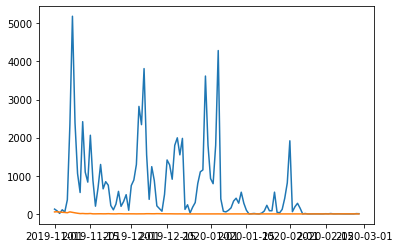

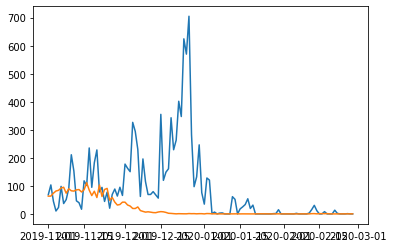

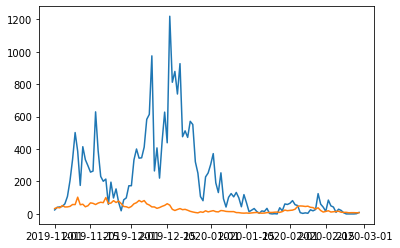

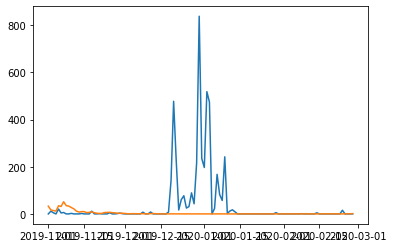

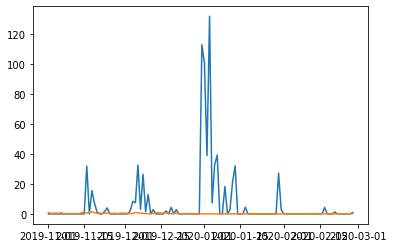

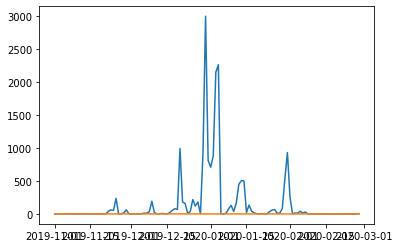

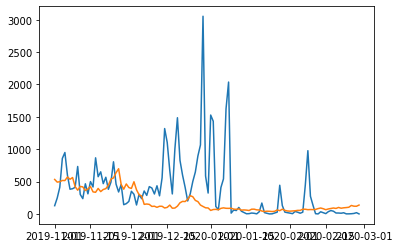

In [26]:
for i,x in zip(_test_pivot.columns, _pred_pivot.columns):
    plt.plot(_test_pivot[i])
    plt.plot(_pred_pivot[i])
    plt.show();

In [27]:
submission = _pred_set[['variable', 'Date', 'Estimated_fire_area']]
submission.rename(columns = {'variable':'Region'}, inplace=True)

C:\Users\albert\Anaconda3\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:

submission

,Region,Date,Estimated_fire_area
37919,NSW,2019-11-01,52.681171
37920,NT,2019-11-01,63.321223
37921,QL,2019-11-01,33.111805
37922,SA,2019-11-01,32.851659
37923,TA,2019-11-01,0.983286
...,...,...,...
38754,QL,2020-02-28,7.595479
38755,SA,2020-02-28,1.209947
38756,TA,2020-02-28,0.158462
38757,VI,2020-02-28,0.602530


In [589]:
submission_df = pd.DataFrame()
for i in regions:
    submission_df = pd.concat([submission_df, submission.loc[submission['Region'].eq(i)]])

In [591]:
submission_df.reset_index(drop=True, inplace=True)
# submisison_df

NameError: name 'submisison_df' is not defined

In [597]:
submission_df = submission_df.loc[submission_df['Date'].gt('2020-01-31')]

In [601]:
submission_df.to_csv('Phase_1_lgbm.csv', index=False,header=True)